In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import time
import os
import gdreg
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statsmodels.stats.multitest import multipletests
from matplotlib import gridspec
import seaborn as sns
import statsmodels.formula.api as smf


# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
DATA_PATH = '/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001_chimp'
# DATA_PATH_CHIMP = '/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001_chimp'
FIG_PATH = '/n/groups/price/martin/data_GDREG/results/fig_res'

# DF_TRAIT, DF_ANNOT, DF_PANNOT
DF_TRAIT = pd.read_csv('/n/groups/price/martin/data_GDREG/results/tables/trait_info.tsv', sep='\t')
DF_TRAIT.index = DF_TRAIT['Trait_Identifier']
TRAIT_LIST = list(DF_TRAIT.index)
print("n_trait=%d" % DF_TRAIT.shape[0])

DF_ANNOT = pd.read_csv('/n/groups/price/martin/data_GDREG/results/tables/annot_info.tsv', sep='\t')
DF_ANNOT.index = DF_ANNOT['Identifier']
print("n_annot=%d" % DF_ANNOT.shape[0])

DF_PANNOT = pd.read_csv('/n/groups/price/martin/data_GDREG/results/tables/pannot_info.tsv', sep='\t')
DF_PANNOT.index = DF_PANNOT['Identifier']
print("n_pannot=%d" % DF_PANNOT.shape[0])

# Others
temp_df = pd.read_csv('../names.tsv', sep='\t', header=None)
DIC_NAME = {x:y for x,y in zip(temp_df[0], temp_df[1])}
DIC_COLOR = {'common_common' : '#78ADD2', 'common' : '#78ADD2', 'common_lf' : '#80C680',
             'lf_lf' : '#FFB26E', 'lf' : '#FFB26E'}
MARKER_LIST=['o', 'v', '^', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', '<', '>']

n_trait=29
n_annot=45
n_pannot=39


In [20]:
# Check ldsc results
def parse_log(fpath):
    with open(fpath, 'r') as f:
        h2,h2_se = 0,0
        for line in f:
            if 'Total Observed scale h2' in line:
                line = line.replace('Total Observed scale h2:','').replace(')','').strip()
                h2 = float(line.split('(')[0])
                h2_se = float(line.split('(')[1])
    return h2,h2_se
                
DIC_RES_PATH = {
    'ldsc_chimp' : '/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001_chimp/ldsc_res/@t.bslLF165',
    'ldsc_major' : '/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/ldsc_res/@t.bslLF165',
}

# Load .pickle files 
dic_res = {}
dic_log = {}
missing_list = []
for md in DIC_RES_PATH:
    dic_res[md] = {}
    dic_log[md] = pd.DataFrame(index=TRAIT_LIST, columns=['h2', 'h2_se'])
    for i,trait in enumerate(TRAIT_LIST):
        res_file = DIC_RES_PATH[md].replace("@t", trait) + '.results'
        log_file = DIC_RES_PATH[md].replace("@t", trait) + '.log'
        if os.path.exists(res_file):
#             dic_res[md][trait] = pd.read_csv(res_file, sep='\t', index_col=0)
#             dic_res[md][trait].index = [x.replace('LD:','').replace('_0','') for x in dic_res[md][trait].index]
            h2,h2_se = parse_log(log_file)
            dic_log[md].loc[trait, ['h2', 'h2_se']] = h2,h2_se
        else:
            print("Missing %-10s %-30s %s" % (md, trait, i+1))
        
#         break
#     break

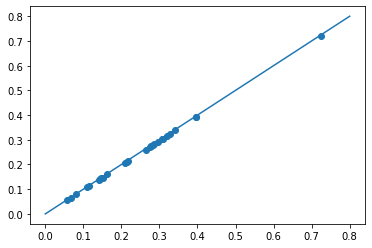

In [22]:
plt.figure()
plt.scatter(dic_log['ldsc_major']['h2'], dic_log['ldsc_chimp']['h2'])
plt.plot([0, 0.8], [0, 0.8])
plt.show()

In [ ]:
trait = 'blood_PLATELET_COUNT'
df_ldsc = pd.read_csv(
    '/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/ldsc_res/blood_PLATELET_COUNT.bslLF165.results', 
    sep='\t', index_col=0
)
df_ldsc.index = [x.replace('LD:','').replace('_0','') for x in df_ldsc.index]

md_ref = 'gdreg_ld'
df_plot = dic_res['gdreg_ld'][trait]['summary']['tau'].copy()
df_plot = df_plot.join(df_ldsc)

# tau estimates 
plt.figure(figsize=[4, 4])
plt.errorbar(
    df_plot['tau'], df_plot['Coefficient'], 
    xerr=df_plot['tau_se'], yerr=df_plot['Coefficient_std_error'],
    fmt = '.', zorder=10, alpha=0.4, color='C0', label='SEs',
)   
plt.legend(loc='upper left', framealpha=0.5)
min_ = min(plt.xlim()[0], plt.ylim()[0])
max_ = max(plt.xlim()[1], plt.ylim()[1])
plt.plot([min_, max_], [min_, max_], '--', linewidth=1, zorder=0, color='darkgray')
plt.plot([min_, max_], [0, 0], '--', linewidth=1, zorder=0, color='darkgray')
plt.plot([0, 0], [min_, max_], '--', linewidth=1, zorder=0, color='darkgray')
plt.xlim([min_, max_])
plt.ylim([min_, max_])
plt.title('Coefficients (cor=%0.3f)' % (np.corrcoef(df_plot['tau'], df_plot['Coefficient'])[0,1]))
plt.xlabel('GDREG')
plt.ylabel('LDSC')
plt.tight_layout()
plt.show()

# h2 estimates 
df_plot['h2_prop'] = df_plot['h2'] / df_plot.loc['AN:all', 'h2']
df_plot['h2_prop_se'] = df_plot['h2_se'] / df_plot.loc['AN:all', 'h2']
plt.figure(figsize=[4, 4])
plt.errorbar(
    df_plot['h2_prop'], df_plot['Prop._h2'],  xerr=df_plot['h2_prop_se'], yerr=df_plot['Prop._h2_std_error'],
    fmt = '.', zorder=10, alpha=0.4, color='C0', label='SEs',
)   
plt.legend(loc='upper left', framealpha=0.5)
min_ = min(plt.xlim()[0], plt.ylim()[0])
max_ = max(plt.xlim()[1], plt.ylim()[1])
plt.plot([min_, max_], [min_, max_], '--', linewidth=1, zorder=0, color='darkgray')
plt.plot([min_, max_], [0, 0], '--', linewidth=1, zorder=0, color='darkgray')
plt.plot([0, 0], [min_, max_], '--', linewidth=1, zorder=0, color='darkgray')
plt.xlim([min_, max_])
plt.ylim([min_, max_])
ind_select = df_plot[['h2_prop', 'Prop._h2']].isna().sum(axis=1)==0
cor = np.corrcoef(df_plot.loc[ind_select, 'h2_prop'], df_plot.loc[ind_select, 'Prop._h2'])[0,1]
plt.title('Heritability (cor=%0.3f)' % cor)
plt.xlabel('GDREG')
plt.ylabel('LDSC')
plt.tight_layout()
plt.show()